## Forecast sales using store, promotion, and competitor data

 Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. 
 Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. 
By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them:
    their customers and their teams! 

In [5]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv



## loading the data

In [6]:
# Import train & test data 
train = pd.read_csv('C:/Users/David/Desktop/rossmann/train.csv')
test = pd.read_csv('C:/Users/David/Desktop/rossmann/test.csv')
store=pd.read_csv('C:/Users/David/Desktop/rossmann/store.csv')
sample_submission = pd.read_csv('C:/Users/David/Desktop/rossmann/sample_submission.csv') # example of what a submission should look like

C:\Users\David\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# View the training data
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
# View the test data (not same columns as the training data doens't have customer and sales, id)
test.head(10) # head = view first 5 lines

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
5,6,10,4,2015-09-17,1.0,1,0,0
6,7,11,4,2015-09-17,1.0,1,0,0
7,8,12,4,2015-09-17,1.0,1,0,0
8,9,13,4,2015-09-17,1.0,1,0,0
9,10,14,4,2015-09-17,1.0,1,0,0


In [9]:
len(test)

41088

In [10]:
len(train)

1017209

In [11]:
len(store)

1115

In [12]:
test.tail(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
41078,41079,1104,6,2015-08-01,1.0,0,0,0
41079,41080,1105,6,2015-08-01,1.0,0,0,0
41080,41081,1106,6,2015-08-01,1.0,0,0,0
41081,41082,1107,6,2015-08-01,1.0,0,0,0
41082,41083,1109,6,2015-08-01,1.0,0,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [13]:
train.tail(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017199,1106,2,2013-01-01,0,0,0,0,a,1
1017200,1107,2,2013-01-01,0,0,0,0,a,1
1017201,1108,2,2013-01-01,0,0,0,0,a,1
1017202,1109,2,2013-01-01,0,0,0,0,a,1
1017203,1110,2,2013-01-01,0,0,0,0,a,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [14]:
store.tail(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1105,1106,a,c,5330.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1106,1107,a,a,1400.0,6.0,2012.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1108,1109,c,a,3490.0,4.0,2011.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## Data description

 Most of the fields are self-explanatory. The following are descriptions for those that aren't.

##### Id  -an Id that represents a (Store, Date) duple within the test set

##### Store - a unique Id for each store

##### Sales - the turnover for any given day (this is what you are predicting)

##### Customers - the number of customers on a given day

##### Open - an indicator for whether the store was open: 0 = closed, 1 = open

##### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.  
                      a = public holiday, 
                      b = Easter holiday, 
                      c = Christmas, 
                      0 = None
                      
##### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

##### StoreType - differentiates between 4 different store models: a, b, c, d

##### Assortment - describes an assortment level: a = basic, b = extra, c = extended

##### CompetitionDistance - distance in meters to the nearest competitor store

##### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

##### Promo - indicates whether a store is running a promo on that day

##### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 
                          0 = store is not participating, 
                          1 = store is participating
                          
##### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

##### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

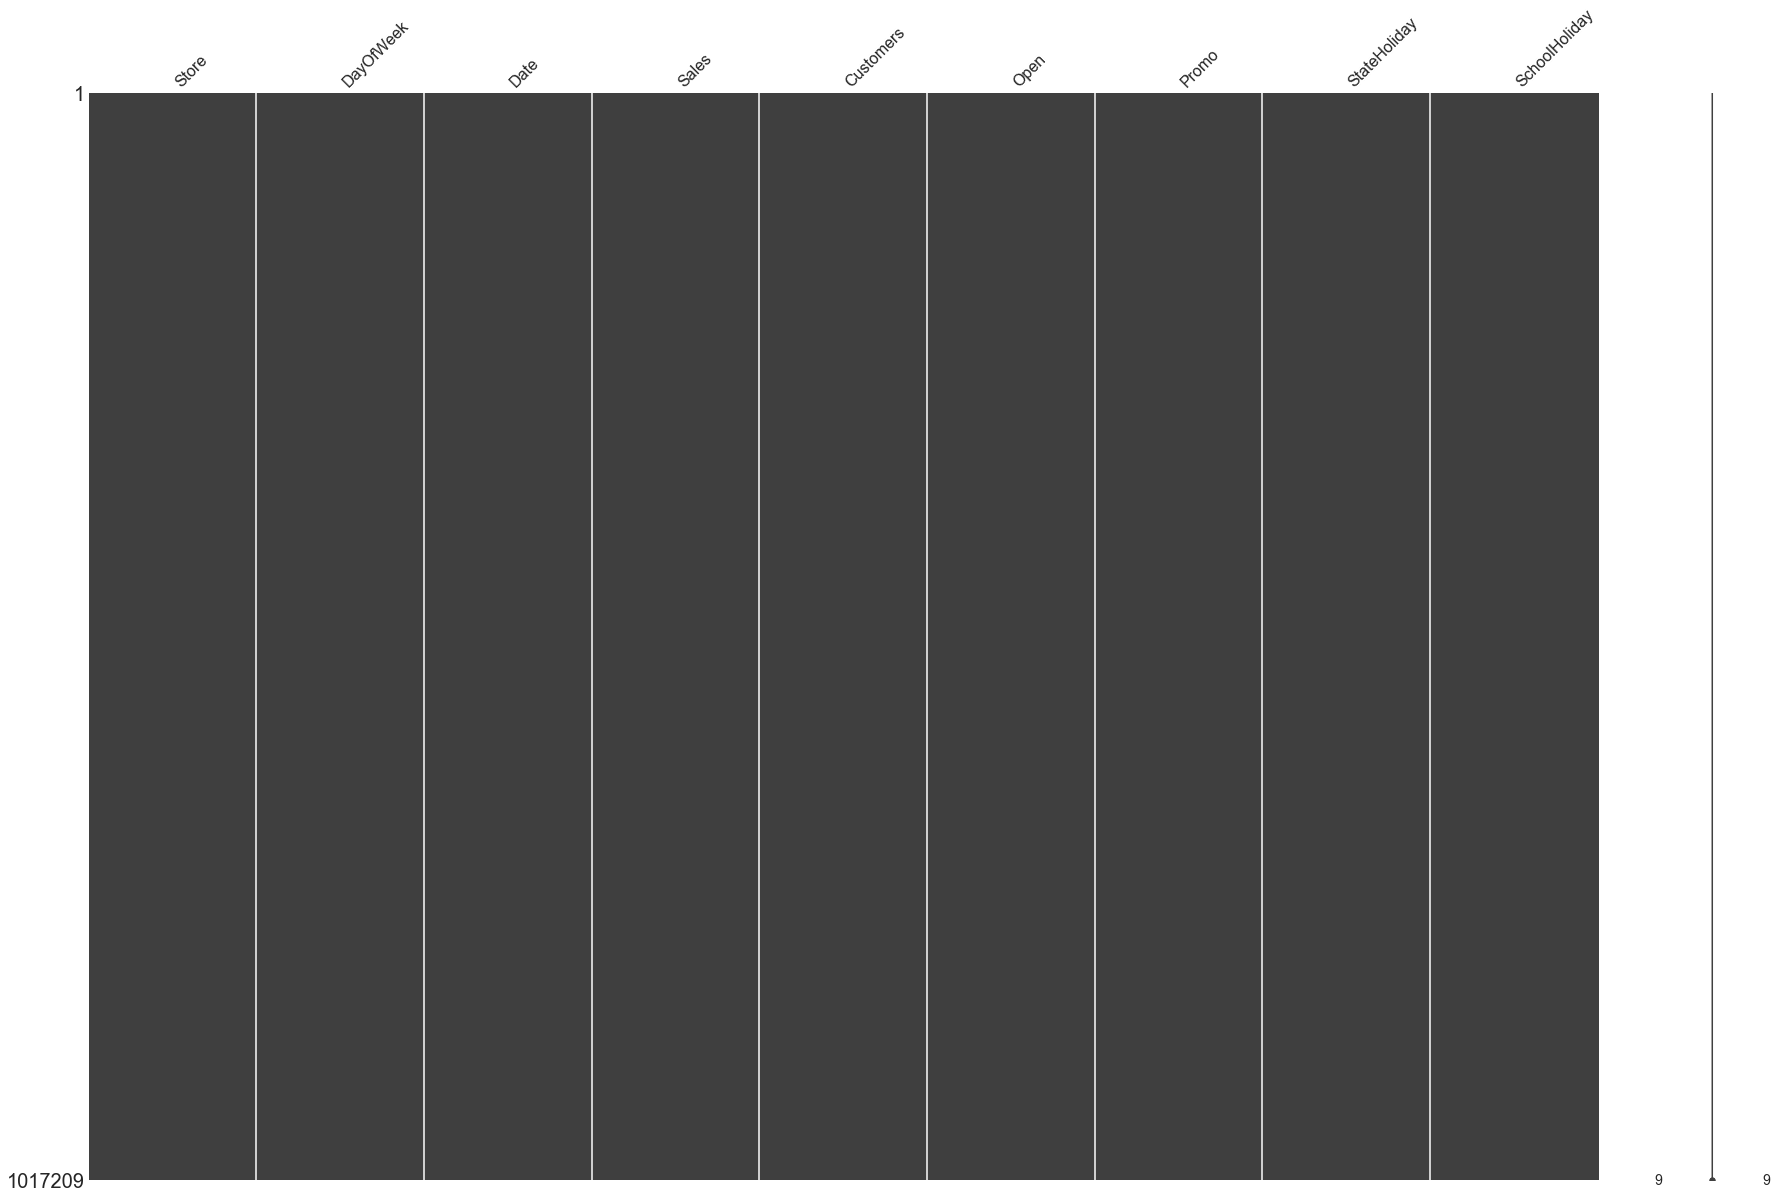

In [15]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,20))
#30 and 10 are pixels

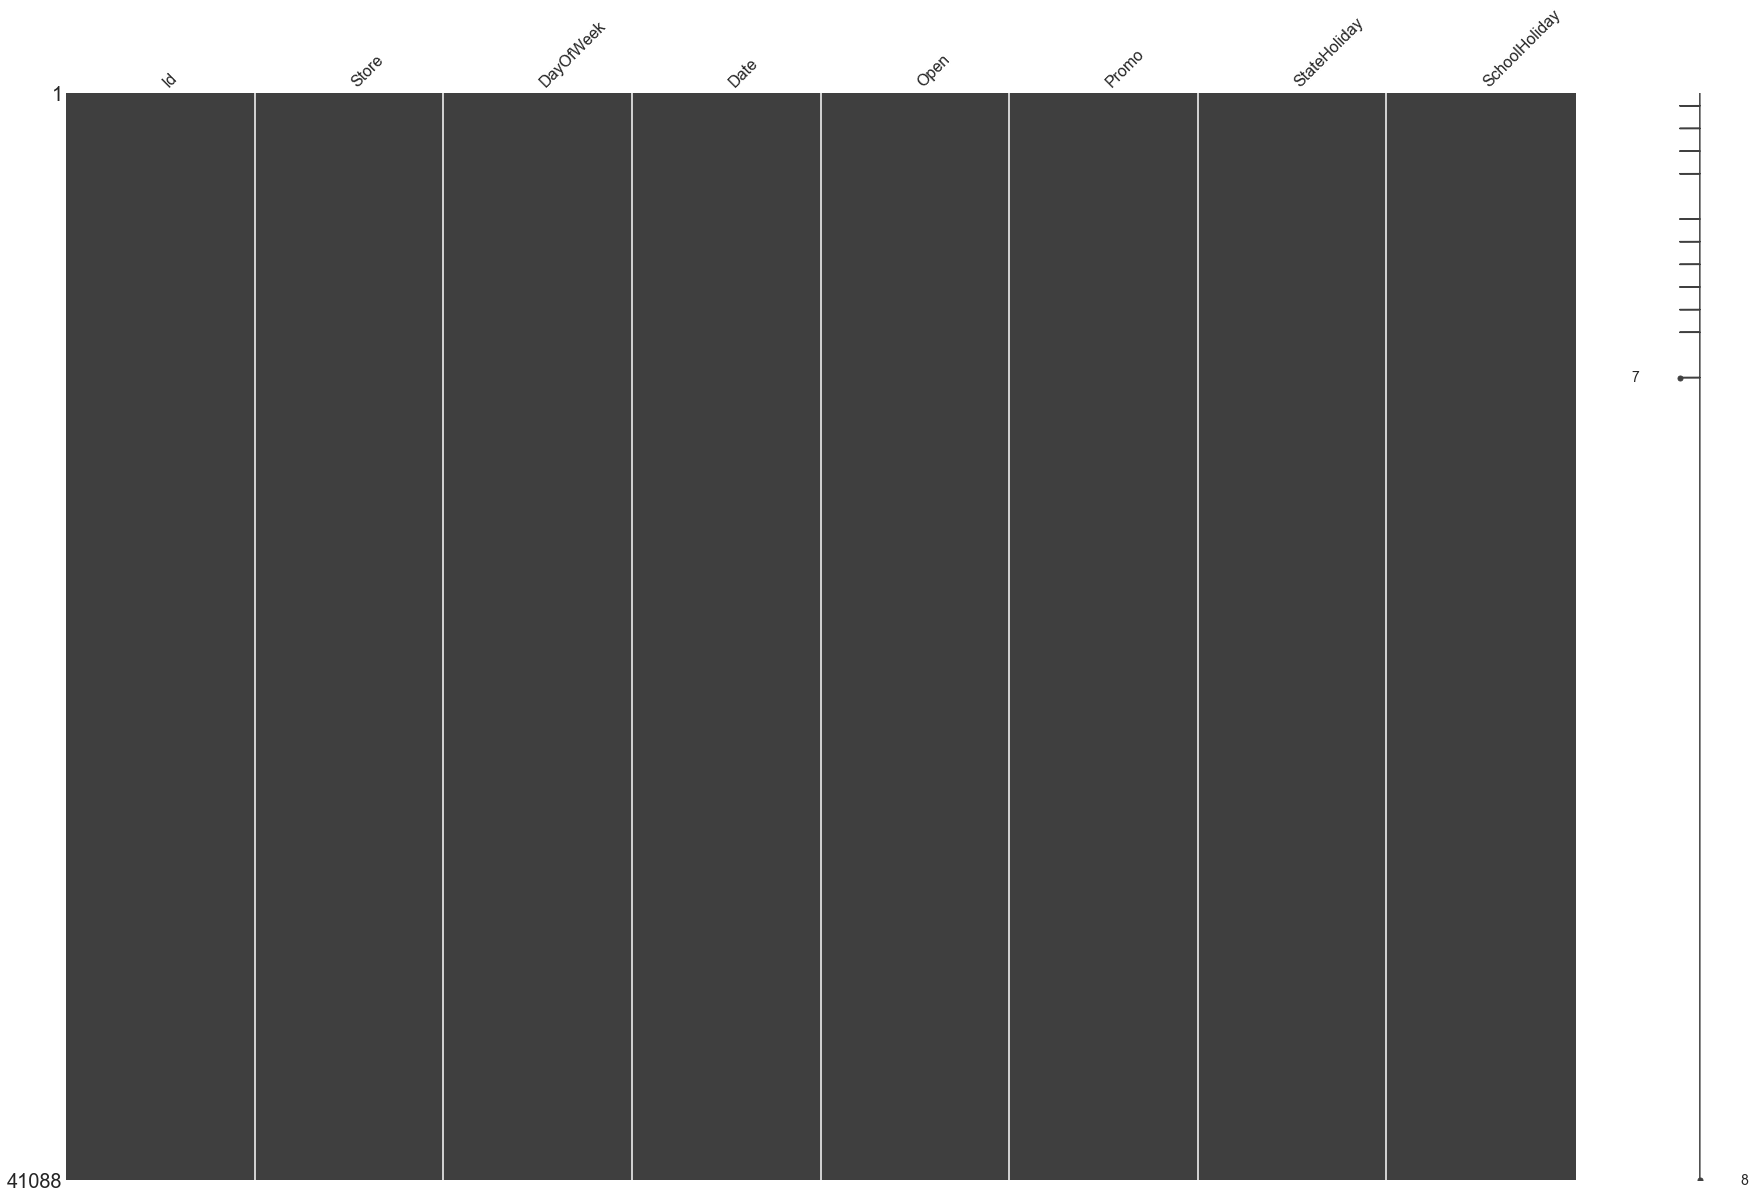

In [16]:
# Plot graphic of missing values
missingno.matrix(test, figsize = (30,20))
#30 and 10 are pixels

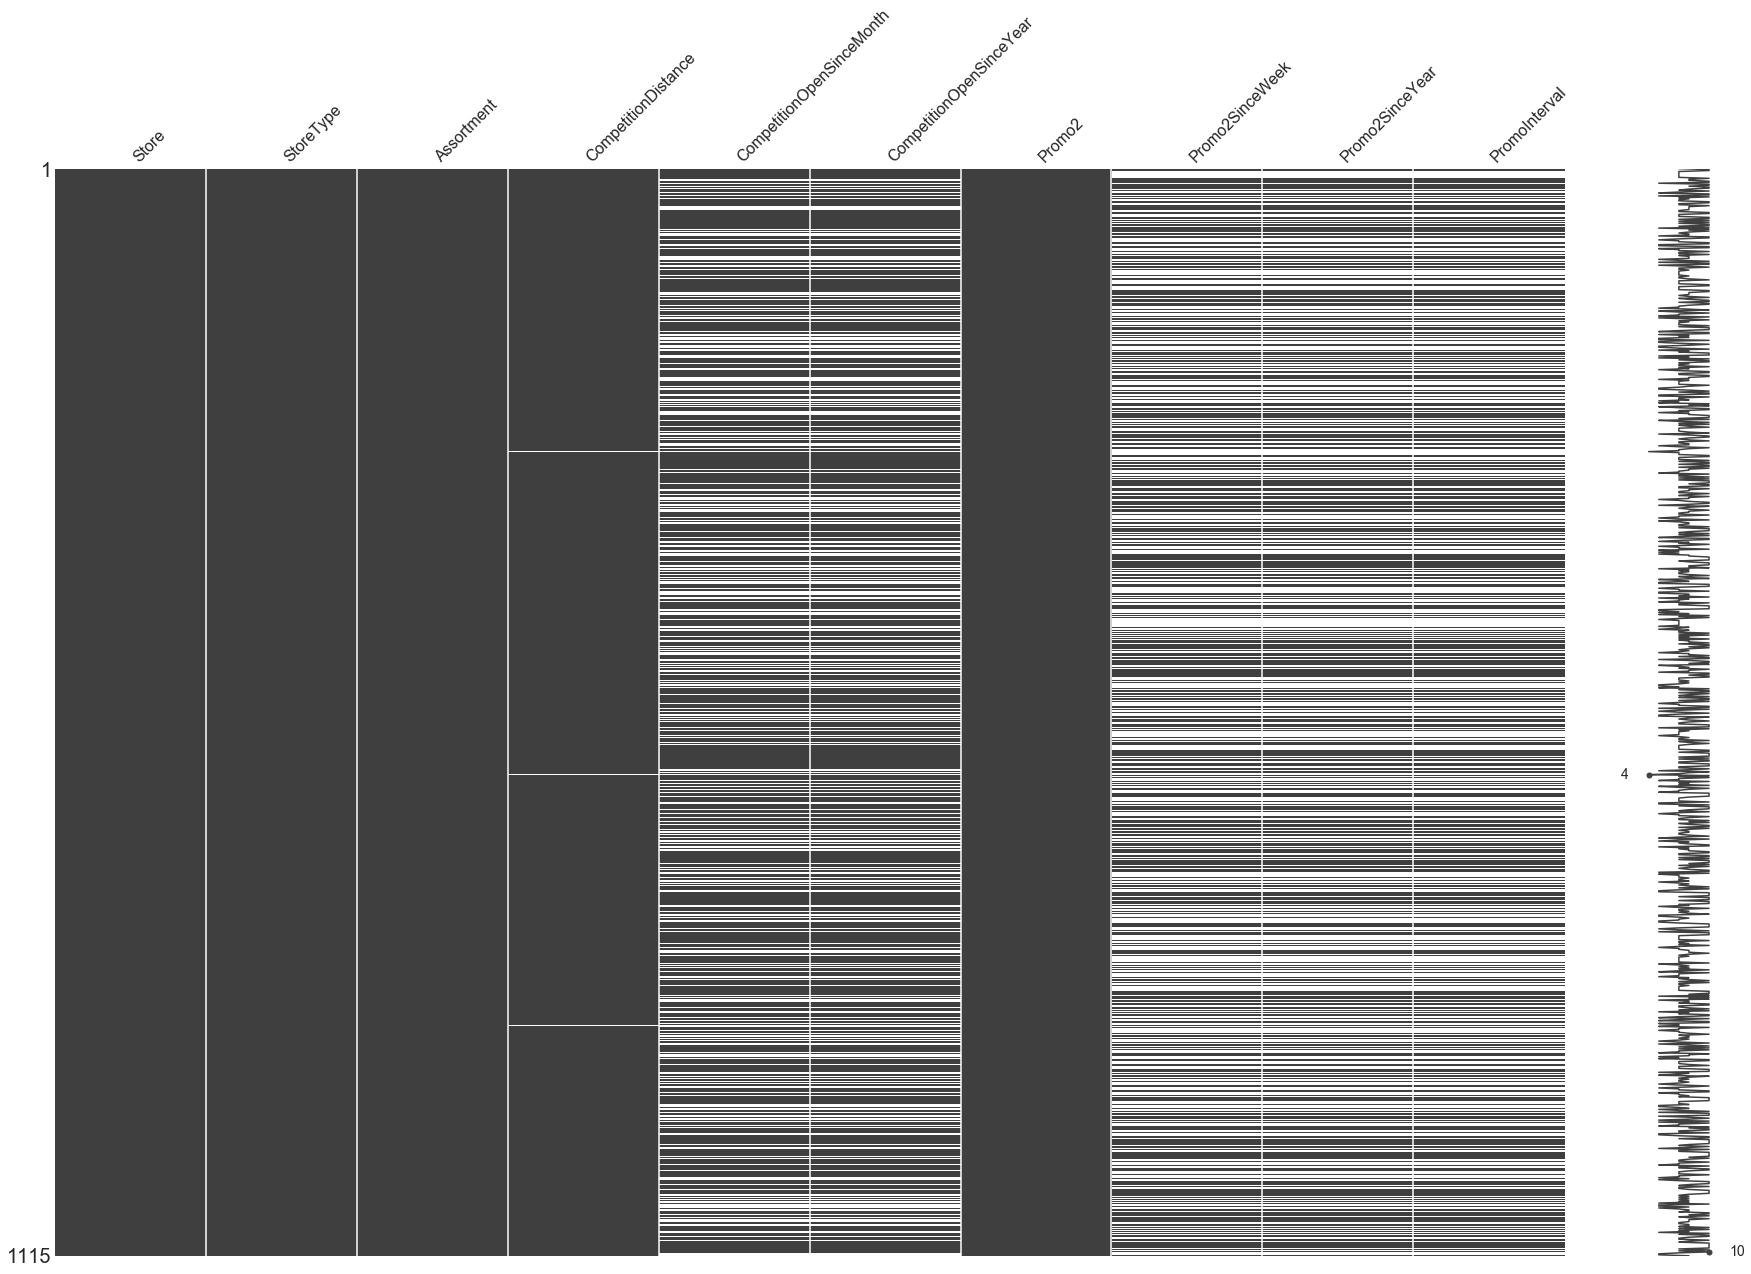

In [17]:
# Plot graphic of missing values
missingno.matrix(store, figsize = (30,20))
#30 and 10 are pixels

In [18]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [19]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [20]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:
# Let's write a little function to show us how many missing values

def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing or NaN values for each column:


{'Store': 0,
 'DayOfWeek': 0,
 'Date': 0,
 'Sales': 0,
 'Customers': 0,
 'Open': 0,
 'Promo': 0,
 'StateHoliday': 0,
 'SchoolHoliday': 0}

In [22]:
# Let's write a little function to show us how many missing values

def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

missing_values = find_missing_values(test, columns=test.columns)
missing_values

Number of missing or NaN values for each column:


{'Id': 0,
 'Store': 0,
 'DayOfWeek': 0,
 'Date': 0,
 'Open': 11,
 'Promo': 0,
 'StateHoliday': 0,
 'SchoolHoliday': 0}

In [23]:
# Let's write a little function to show us how many missing values

def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

missing_values = find_missing_values(store, columns=store.columns)
missing_values

Number of missing or NaN values for each column:


{'Store': 0,
 'StoreType': 0,
 'Assortment': 0,
 'CompetitionDistance': 3,
 'CompetitionOpenSinceMonth': 354,
 'CompetitionOpenSinceYear': 354,
 'Promo2': 0,
 'Promo2SinceWeek': 544,
 'Promo2SinceYear': 544,
 'PromoInterval': 544}

## To perform our data analysis, let's create two new dataframes
i will create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [24]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

## What datatypes are in the dataframe?

In [25]:
# Different data types in the dataset
train.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [26]:
# Different data types in the dataset
test.dtypes

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [27]:
# Different data types in the dataset
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

## Let's explore each of these features individually

### Target Feature: Sales

Description:  the turnover for any given day

In [28]:
import plotly.plotly as py
import plotly.graph_objs as go

Create new columns Year and Month to be used in the analysis of seasonal effects on sales.

In [29]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month

In [30]:
train = train[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Customers', 'Open',
               'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales']]
list(train.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Sales']

In [31]:
train.head(3)

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,5,2015-07-31,2015,7,555,1,1,0,1,5263
1,2,5,2015-07-31,2015,7,625,1,1,0,1,6064
2,3,5,2015-07-31,2015,7,821,1,1,0,1,8314


Types of holidats

In [32]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

convert categorical data to numeric data for state holiday

In [33]:
train.loc[train['StateHoliday'] == '0', 'StateHoliday'] = 0
train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = 1
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = 2
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = 3
train['StateHoliday'] = train['StateHoliday'].astype(int, copy=False)

In [34]:
train.head(10)

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,5,2015-07-31,2015,7,555,1,1,0,1,5263
1,2,5,2015-07-31,2015,7,625,1,1,0,1,6064
2,3,5,2015-07-31,2015,7,821,1,1,0,1,8314
3,4,5,2015-07-31,2015,7,1498,1,1,0,1,13995
4,5,5,2015-07-31,2015,7,559,1,1,0,1,4822
5,6,5,2015-07-31,2015,7,589,1,1,0,1,5651
6,7,5,2015-07-31,2015,7,1414,1,1,0,1,15344
7,8,5,2015-07-31,2015,7,833,1,1,0,1,8492
8,9,5,2015-07-31,2015,7,687,1,1,0,1,8565
9,10,5,2015-07-31,2015,7,681,1,1,0,1,7185


School holidays how many we have

In [35]:
train['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

View of data

In [36]:
print(train.describe())

              Store     DayOfWeek          Year         Month     Customers  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  2.013832e+03  5.846762e+00  6.331459e+02   
std    3.219087e+02  1.997391e+00  7.773960e-01  3.326097e+00  4.644117e+02   
min    1.000000e+00  1.000000e+00  2.013000e+03  1.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  2.013000e+03  3.000000e+00  4.050000e+02   
50%    5.580000e+02  4.000000e+00  2.014000e+03  6.000000e+00  6.090000e+02   
75%    8.380000e+02  6.000000e+00  2.014000e+03  8.000000e+00  8.370000e+02   
max    1.115000e+03  7.000000e+00  2.015000e+03  1.200000e+01  7.388000e+03   

               Open         Promo  StateHoliday  SchoolHoliday         Sales  
count  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06  1.017209e+06  
mean   8.301067e-01  3.815145e-01  4.516279e-02   1.786467e-01  5.773819e+03  
std    3.755392e-01  4.857586e-01  2.836559e-01   3

Check open day

In [37]:
train['Open'].unique()

array([1, 0], dtype=int64)

## analysing test data set

In [38]:
test.shape

(41088, 8)

In [39]:
test['Year'] = pd.DatetimeIndex(test['Date']).year
test['Month'] = pd.DatetimeIndex(test['Date']).month

In [40]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9


Change the column names of the test dataset to get construct same feature names with the train dataset.

In [41]:
test = test[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Open',
             'Promo', 'StateHoliday', 'SchoolHoliday']]
list(test.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday']

check information about a particular store 

In [42]:
print(train.ix[train['Store'] == 22])

         Store  DayOfWeek        Date  Year  Month  Customers  Open  Promo  \
21          22          5  2015-07-31  2015      7        633     1      1   
1136        22          4  2015-07-30  2015      7        575     1      1   
2251        22          3  2015-07-29  2015      7        525     1      1   
3366        22          2  2015-07-28  2015      7        525     1      1   
4481        22          1  2015-07-27  2015      7        621     1      1   
5596        22          7  2015-07-26  2015      7          0     0      0   
6711        22          6  2015-07-25  2015      7        415     1      0   
7826        22          5  2015-07-24  2015      7        592     1      0   
8941        22          4  2015-07-23  2015      7        501     1      0   
10056       22          3  2015-07-22  2015      7        436     1      0   
11171       22          2  2015-07-21  2015      7        468     1      0   
12286       22          1  2015-07-20  2015      7        503   

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [43]:
test.dtypes

Store              int64
DayOfWeek          int64
Date              object
Year               int64
Month              int64
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [44]:
test['StateHoliday'].unique()

array(['0', 'a'], dtype=object)

In [45]:
test['SchoolHoliday'].unique()

array([0, 1], dtype=int64)

convert categorical data into state holiday into numerical data 

In [46]:
test.dtypes

Store              int64
DayOfWeek          int64
Date              object
Year               int64
Month              int64
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [47]:
test

,Store,DayOfWeek,Date,Year,Month,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,2015,9,1.0,1,0,0
1,3,4,2015-09-17,2015,9,1.0,1,0,0
2,7,4,2015-09-17,2015,9,1.0,1,0,0
3,8,4,2015-09-17,2015,9,1.0,1,0,0
4,9,4,2015-09-17,2015,9,1.0,1,0,0
5,10,4,2015-09-17,2015,9,1.0,1,0,0
6,11,4,2015-09-17,2015,9,1.0,1,0,0
7,12,4,2015-09-17,2015,9,1.0,1,0,0
8,13,4,2015-09-17,2015,9,1.0,1,0,0
9,14,4,2015-09-17,2015,9,1.0,1,0,0


In [48]:
train

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,5,2015-07-31,2015,7,555,1,1,0,1,5263
1,2,5,2015-07-31,2015,7,625,1,1,0,1,6064
2,3,5,2015-07-31,2015,7,821,1,1,0,1,8314
3,4,5,2015-07-31,2015,7,1498,1,1,0,1,13995
4,5,5,2015-07-31,2015,7,559,1,1,0,1,4822
5,6,5,2015-07-31,2015,7,589,1,1,0,1,5651
6,7,5,2015-07-31,2015,7,1414,1,1,0,1,15344
7,8,5,2015-07-31,2015,7,833,1,1,0,1,8492
8,9,5,2015-07-31,2015,7,687,1,1,0,1,8565
9,10,5,2015-07-31,2015,7,681,1,1,0,1,7185


# Store Dataset

In [49]:
store.shape

(1115, 10)

In [50]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [51]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


Change the categorical values (string type) of StoreType and Assortment columns to integers. Check the results.

In [52]:
store.loc[store['StoreType'] == 'a', 'StoreType'] = 1
store.loc[store['StoreType'] == 'b', 'StoreType'] = 2
store.loc[store['StoreType'] == 'c', 'StoreType'] = 3
store.loc[store['StoreType'] == 'd', 'StoreType'] = 4
store['StoreType'] = store['StoreType'].astype(int, copy=False)

In [53]:
print('levels :', store['StoreType'].unique(), '; data type :', store['StoreType'].dtype)

levels : [3 1 4 2] ; data type : int32


In [54]:
store.loc[store['Assortment'] == 'a', 'Assortment'] = 1
store.loc[store['Assortment'] == 'b', 'Assortment'] = 2
store.loc[store['Assortment'] == 'c', 'Assortment'] = 3
store['Assortment'] = store['Assortment'].astype(int, copy=False)

In [55]:
print('levels :', store['Assortment'].unique(), '; data type :', store['Assortment'].dtype)

levels : [1 3 2] ; data type : int32


In [56]:
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [57]:
store.dtypes

Store                          int64
StoreType                      int32
Assortment                     int32
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [58]:
store = store.fillna(0)
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0
5,6,1,1,310.0,12.0,2013.0,0,0.0,0.0,0
6,7,1,3,24000.0,4.0,2013.0,0,0.0,0.0,0
7,8,1,1,7520.0,10.0,2014.0,0,0.0,0.0,0
8,9,1,3,2030.0,8.0,2000.0,0,0.0,0.0,0
9,10,1,1,3160.0,9.0,2009.0,0,0.0,0.0,0


In [59]:

store.loc[store['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = 1
store.loc[store['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = 2
store.loc[store['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = 3
store['PromoInterval'] = store['PromoInterval'].astype(int, copy=False)

Merge train and store datasets before modeling the data.

In [60]:
train_store = pd.merge(train, store, how = 'left', on='Store')

In [61]:
train_store

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,2015,7,555,1,1,0,1,5263,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,2015,7,625,1,1,0,1,6064,1,1,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,2015-07-31,2015,7,821,1,1,0,1,8314,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,2015-07-31,2015,7,1498,1,1,0,1,13995,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,2015,7,559,1,1,0,1,4822,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0
5,6,5,2015-07-31,2015,7,589,1,1,0,1,5651,1,1,310.0,12.0,2013.0,0,0.0,0.0,0
6,7,5,2015-07-31,2015,7,1414,1,1,0,1,15344,1,3,24000.0,4.0,2013.0,0,0.0,0.0,0
7,8,5,2015-07-31,2015,7,833,1,1,0,1,8492,1,1,7520.0,10.0,2014.0,0,0.0,0.0,0
8,9,5,2015-07-31,2015,7,687,1,1,0,1,8565,1,3,2030.0,8.0,2000.0,0,0.0,0.0,0
9,10,5,2015-07-31,2015,7,681,1,1,0,1,7185,1,1,3160.0,9.0,2009.0,0,0.0,0.0,0


## Visual Exploration

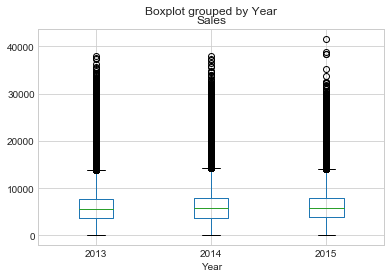

In [62]:
train_store.boxplot(column='Sales', by='Year')
plt.show()

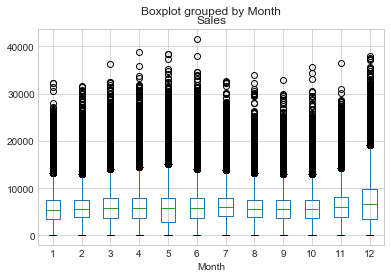

In [63]:
train_store.boxplot(column='Sales', by='Month')
plt.show()

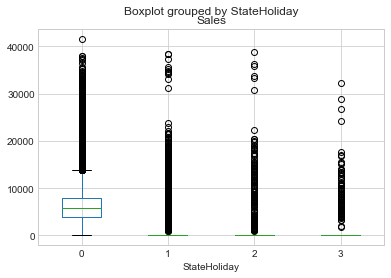

In [64]:
train_store.boxplot(column='Sales', by='StateHoliday')
plt.show()

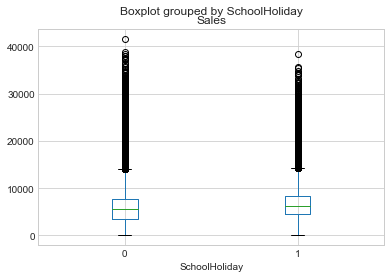

In [65]:
train_store.boxplot(column='Sales', by='SchoolHoliday')
plt.show()

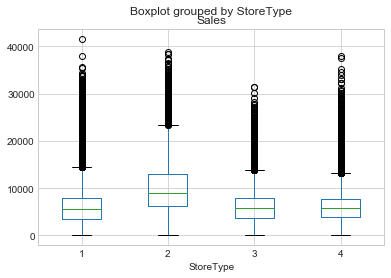

In [66]:
train_store.boxplot(column='Sales', by='StoreType')
plt.show()

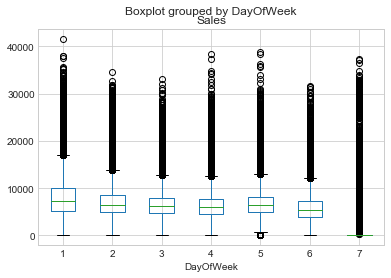

In [67]:
train_store.boxplot(column='Sales', by='DayOfWeek')
plt.show()

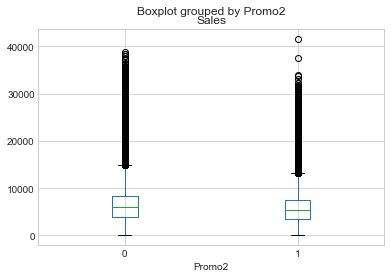

In [68]:
train_store.boxplot(column='Sales', by='Promo2')
plt.show()

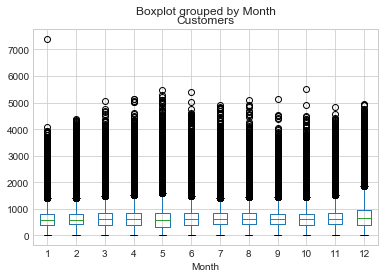

In [69]:
train_store.boxplot(column='Customers', by='Month')
plt.show()

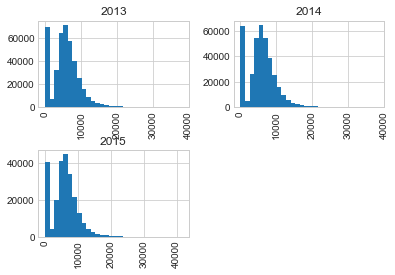

In [70]:
train_store.hist(column='Sales', by='Year', bins=30)
plt.show()

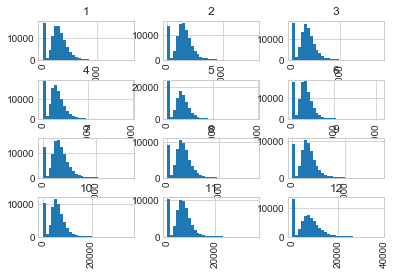

In [71]:
train_store.hist(column='Sales', by='Month', bins=30)
plt.show()

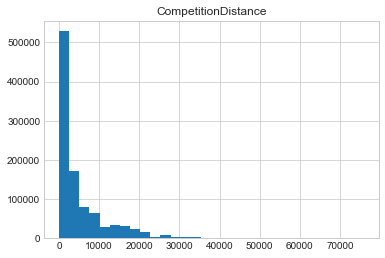

In [72]:
train_store.hist(column='CompetitionDistance', bins=30)
plt.show()

## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data